# **Sentiment Anaysis using BERT**

### **What is Bert?**
BERT stands for Bidirectional Encoder Representations from Transformers.It It is an open source machine learning framework for natural language processing (NLP) developed by **Google**.It is basically trained on large book corpus and we are gonna leverage that trained parameters for our tasks.

## All right, Lets dive into the coding part

We are gonna levearage free GPU's provided by Google in colab interactive platform for training our model.

The followig code will test's for GPU and yeah! we got GPU. 



In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not... 
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Transformers
Transfromers is an model arcitecture which uses stacked self-attention and point-wise, fully connected layers for both the encoder and decoder
 
we will install this using following codes

In [2]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Module for downloading the files

In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9681 sha256=11011ee7bca92aee90811a332ed63f0a26c44f1d68bb76c4ede25cbc94bd2f9c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Downloading Dataset "yelp reviews" from fast.ai into our colab directory.
you can learn more about fast.ai using this link https://www.fast.ai/2020/02/13/fastai-A-Layered-API-for-Deep-Learning/
also you can download the dataset from here https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz

In [4]:
import wget
import os

!wget clone https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz

--2020-12-27 07:04:01--  http://clone/
Resolving clone (clone)... failed: Name or service not known.
wget: unable to resolve host address ‘clone’
--2020-12-27 07:04:01--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.207.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.207.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196146755 (187M) [application/x-tar]
Saving to: ‘yelp_review_full_csv.tgz’

yelp_review_full_cs 100%[===================>] 187.06M  48.1MB/s    in 3.8s    

2020-12-27 07:04:05 (48.6 MB/s) - ‘yelp_review_full_csv.tgz’ saved [196146755/196146755]

FINISHED --2020-12-27 07:04:05--
Total wall clock time: 4.3s
Downloaded: 1 files, 187M in 3.8s (48.6 MB/s)


Following code Unzips the downloaded file

In [5]:
import tarfile
filename="./yelp_review_full_csv.tgz"
with tarfile.open(filename,"r") as tar:
  tar.extractall()
  print("Done")

Done


### Importing Data
We have two datasets namely test.csv and train.csv.
Let's quickly load them using Pandas library.

In [6]:
import pandas as pd
df_train=pd.read_csv("./yelp_review_full_csv/train.csv",nrows=200000,names=["labels","sentences"])
df_test=pd.read_csv("./yelp_review_full_csv/test.csv",nrows=25000,names=["labels","sentences"])

We have 6 Lakh 50 thousand data points which is very good for training our model.

In [7]:
df_train.head(5)

,labels,sentences
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   labels     200000 non-null  int64 
 1   sentences  200000 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


and we have 50 thousand datapoints for testing purposes

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   labels     25000 non-null  int64 
 1   sentences  25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


will checkout how many lables present in the model that we are gonna predict.

In [10]:
df_train.labels.unique()

array([5, 2, 4, 1, 3])

We have 5 labels and they starts from index 1. For our convniences,will change the lables starting position from 0.

In [11]:
df_train.labels=df_train.labels-1

Storing sentences and values into a python list for further process

In [12]:
sentences=df_train.sentences.values
labels=df_train.labels.values

Let's do a quick anaysis, to find whether our dataset is well balanced or not

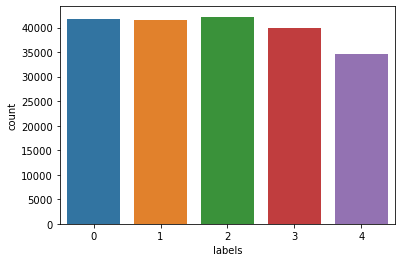

In [13]:
import seaborn as sns
sns.countplot(df_train.labels);

Bert can handle 512 tokens as input,let's check how many sentences has token length more than 512.

In [14]:
z=[]
for i in sentences:
  if len(i.split())>512:
    z.append(len(i.split()))
print("We have {} sentences having tokens longer than 512 " .format(len(z)))

We have 3584 sentences having tokens longer than 512 


### All right, before we begin let's understand the pipeline.

1. Tokenization

2. Make a datset

3. Divide the dataset into batches

4. Import pretrained BERT model

5. Define optimizer and learning rate

6. Train our model

7. Evalauate

Since Bert model is already trained, we will use that same information for creating tokens for our model.

Now you must know about **"huggingface"**,
Huggingface is a brilliant source for many different model architectures for our NLP tasks.

you can explore them using this link https://huggingface.co/

In [15]:
from transformers import BertTokenizer

# Load the bert tokenizer.
print("Loading Bert tokanizer")
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Loading Bert tokanizer


Creating tokens and ids for a single sentences for clear understanding 

In [16]:
# print the original sentence
print(" Original:", sentences[0])
print(len(sentences[0]))

# print the sentence split into tokens
print(" tokenized:",tokenizer.tokenize(sentences[0]))
print(len(tokenizer.tokenize(sentences[0])))
# print the sentence mapped to the token ids
print("Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))
max_length=300
print("attention_masks:",tokenizer.encode(sentences[0], add_special_tokens=True,truncation=True,
                          return_attention_masks=True,padding = "max_length"))

 Original: dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.
534
 tokenized: ['dr', '.', 'goldberg', 'offers', 'everything', 'i', 'look', 'for', 'in', 'a', 'general', 'practitioner', '.', 'he', "'", 's', 'nice', 'and', 'easy', 'to', 'talk', 'to', 'without', 'being', 'patron', '##izing', ';', 'he', "'", 's', 'always', 'on', 'time', 'in', 'seeing', 'his', 'patients', ';', 'he', "'", 's', 'affiliated', 'with', 'a', 'top', '-', 'notch', 'hospital', '(', 'nyu', ')', 'which', 'my', 'parents', 'have', 'explained', 't

Here is the code for creating inputs ids and attention masks for entire sentences in our dataset.

I have used max length to 150 to avoid "cuda out of memory error".

If you have good GPU then you can free to use full length of tokens, sorry 512 tokens max.

In [17]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]
                        # padding=True,
                        max_length = 200,          # Pad & truncate all sentences.
                        truncation= True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',    # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.
Token IDs: tensor([  101,  2852,  1012, 18522,  4107,  2673,  1045,  2298,  2005,  1999,
         1037,  2236, 18742,  1012,  2002,  1005,  1055,  3835,  1998,  3733,
         2000,  2831,  2000,  2302,  2108,  9161,  6026,  1025,  2002,  1005,
         1055,  2467,  2006,  2051,  1999,  3773,  2010,  5022,  1025,  2002,
         1005,  1055,  6989,  2007,  1037,  2327,  1011, 18624,  2902,  1006,
        27935,  1007,  2029,  2026,  3008,  2031,  45

Creating a Tensor dataset and spliting it for traing and validation

In [18]:
from torch.utils.data import TensorDataset, random_split

#combine the training inputs into tensordataset
dataset = TensorDataset(input_ids,attention_masks,labels)

#create a 80-20 train-validation split


#calculate the number of samples to include in each set.
train_size=int(0.8*len(dataset))
val_size=len(dataset)-train_size

#divide the dataset by randomly selecting samples.
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])

print("{:>5,} training samples".format(train_size))
print("{:>5,} validation samples".format(val_size))


160,000 training samples
40,000 validation samples


Here we are creating dataloader of batch size 32.We wil take traing samples in random order and for validation we will read it sequentially

In [19]:
from torch.utils.data import DataLoader, RandomSampler,SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, 
    sampler=RandomSampler(train_dataset), 
    batch_size=batch_size
    )

validation_dataloader=DataLoader(
    val_dataset, 
    sampler=SequentialSampler(val_dataset), 
    batch_size=batch_size
)

Will Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top and we will modify the classification layer to predict for 5 classes.

Moving the model into GPU

In [20]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification. 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# moving this model to the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Just out of curiousity we are checking model parameters and it's weights

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

We are gonna use AdamW as an optimizer and it is a class from the huggingface library.

In [22]:
optimizer=AdamW(model.parameters(),
                lr=2e-5, #args.learning rate-default is 5e-5,our note book has 2e-5
                eps=1e-8 #args.adam_epsilon --default is le-8
                )

The BERT authors recommend between 2 and 4 epochs. 
We chose to run for 2, but we'll see later that this may be over-fitting or underfitting the trianing data

we will use scheduler function for updating the learning rate.

In [23]:
from transformers import get_linear_schedule_with_warmup


epochs = 2
#  Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples)

total_steps=len(train_dataloader)*epochs

scheduler =get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps =0,#default values is run_glue.py
                                           num_training_steps =total_steps
                                           )

Function to calculate the accuracy of our predictions vs labels

In [24]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Create a function to track the time in our model while traning

In [25]:
import time
import datetime

def format_time(elapsed):

  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''

  #Round to the nearest second
  elapsed_rounded = int(round((elapsed)))

  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))
  



In [26]:
# torch.cuda.empty_cache() 

### Here is the complete code for traning our model. 

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  5,000.    Elapsed: 0:01:01.
  Batch   200  of  5,000.    Elapsed: 0:02:02.
  Batch   300  of  5,000.    Elapsed: 0:03:02.
  Batch   400  of  5,000.    Elapsed: 0:04:02.
  Batch   500  of  5,000.    Elapsed: 0:05:03.
  Batch   600  of  5,000.    Elapsed: 0:06:03.
  Batch   700  of  5,000.    Elapsed: 0:07:03.
  Batch   800  of  5,000.    Elapsed: 0:08:04.
  Batch   900  of  5,000.    Elapsed: 0:09:04.
  Batch 1,000  of  5,000.    Elapsed: 0:10:04.
  Batch 1,100  of  5,000.    Elapsed: 0:11:05.
  Batch 1,200  of  5,000.    Elapsed: 0:12:05.
  Batch 1,300  of  5,000.    Elapsed: 0:13:05.
  Batch 1,400  of  5,000.    Elapsed: 0:14:06.
  Batch 1,500  of  5,000.    Elapsed: 0:15:06.
  Batch 1,600  of  5,000.    Elapsed: 0:16:06.
  Batch 1,700  of  5,000.    Elapsed: 0:17:07.
  Batch 1,800  of  5,000.    Elapsed: 0:18:07.
  Batch 1,900  of  5,000.    Elapsed: 0:19:07.
  Batch 2,000  of  5,000.    Elapsed: 0:20:08.
  Batch 2,100  of

Create a DataFrame from our training statistics

In [ ]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

Plotting Learning curve vs validation curve

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

Now we will prepare the dataloader usig testing dataset for predictions.

In [ ]:

print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))


sentences = df_test.sentences.values
labels = df_test.labels.values

input_ids = []
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(
                        sent[0:200],                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 200,
                        truncation=True,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
 
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

following code will be used for evaluating our model.


In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

# Saving our model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'
# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


# saving our model into google drive for future use and deployment purpose

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "bert_yelp"

# Loading saved model for predictions

In [ ]:
import torch
import numpy as np
from transformers import BertConfig,BertForSequenceClassification,BertTokenizer
config = BertConfig.from_json_file("config.json")
model = BertForSequenceClassification(config)
state_dict = torch.load("pytorch_model.bin")
model.load_state_dict(state_dict)
tokenizer = BertTokenizer("vocab.txt", do_lower_case=True)


In [ ]:
def sentiment_anaysis():
  input_sentence=input()
  ratings=["Worst","Poor","Average","Good","Excellent"]
  encoded_dict=tokenizer.encode_plus(input_sentence,add_special_tokens=True,max_length=250,
                                    truncation=True,padding="max_length",return_attention_mask=True,return_tensors="pt")
  input_ids=encoded_dict["input_ids"]
  attention_masks=encoded_dict["attention_mask"]
  model.eval()
  with torch.no_grad():
    output=model(input_ids, token_type_ids=None, 
                        attention_mask=attention_masks)
    out=ratings[np.argmax(output[0][0].numpy())]
  print("\nyou have given {} ratings".format(out))

In [ ]:
sentiment_anaysis()

In [ ]:
sentiment_anaysis()